In [ ]:
""" Helper imports"""
import pandas as pd
import numpy as np
from datetime import date, timedelta

""" Plotting imports"""
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

""" Google imports"""
from google.cloud import bigquery

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Modeling imports"""

import umap
import hdbscan
from sentence_transformers import SentenceTransformer

**READ DATA**

In [5]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

df = pd.read_csv(data_path + 'raw/articles.csv')

In [6]:
print(len(df.tier1.unique()))
df.tier1.value_counts()

29


Business and Finance        245
Personal Finance            120
Sports                       89
Technology & Computing       73
Medical Health               71
News and Politics            64
Video Gaming                 34
Automotive                   30
Food & Drink                 23
Travel                       23
Real Estate                  22
Style & Fashion              22
Events and Attractions       22
Careers                      21
Education                    19
Music and Audio              18
Shopping                     18
Science                      17
Movies                       17
Television                   13
Home & Garden                 7
Family and Relationships      6
Healthy Living                5
Hobbies & Interests           4
Pop Culture                   3
Fine Art                      2
Books and Literature          2
Pets                          1
Religion & Spirituality       1
Name: tier1, dtype: int64

In [8]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = nltk.word_tokenize(text)
    text = [x.lower() for x in text]
    text = [w for w in text if w not in STOP_WORDS]   
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [w for w in text if w not in list(set(string.punctuation))]
    text = [re.sub('[0-9]+', '', x) for x in text]
    text = [x for x in text if len(x) > 1]
    
    return text

df['processed'] = df['clean_body'].apply(clean_text) 

In [10]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns #' '.join(all_nouns)

df['processed_noun'] = df.clean_body.apply(nouns)

df['processed_noun_2'] = df.processed_noun.apply(lambda x: ' '.join([str(elem) for elem in list(set(x))]))

In [14]:
# just one outlier
df[df["max_sent_len"]>500].shape

(1, 13)

In [15]:
df.head(1)

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body,processed,processed_noun,processed_noun_2,article_length,max_sent_len
0,Computer Software and Applications,Technology & Computing,Computing,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,"[id=23]<h2 class=""subhead-embed color-accent bg-base font-accent font-size text-align"">OBSERVATIONS FROM T...",76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tan...,"[smartphone, owner, use, mobile, manage, finance, observation, fintech, snark, tank, new, study, cornersto...","[%, smartphone, owners, apps, finances, observations, fintech, snark, study, cornerstone, advisors, %, sma...",amzn cardmeaning billion+ drop arena today apple displacement utilization gen respondents click card years...,777,49


### ALGO 1: Article as sentence embedding + HDBSCAN 

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [16]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

def algo(data):
    
    # get embeddings
    embeddings = model.encode(data) # 30sec
    
    # dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings) #min_dist=0.0,
    
    # cluster
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    # plot clusters and outliers
    # prepare data  - reduce to 2D for the purpose of plotting
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD') #, s=20 lw=10
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r') # s=0.05, lw=10
    plt.colorbar()
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
    
    return docs_df, top_n_words, topic_sizes

Orig - initial try

992


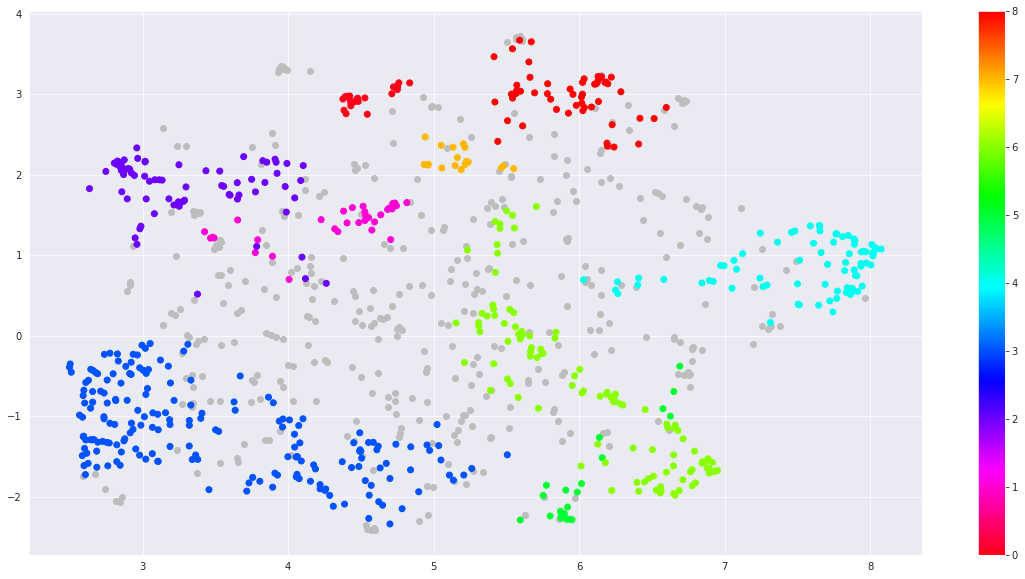

In [24]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=15, input = full article

data = df.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 2mins

In [25]:
topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,393
1,0,22
2,1,32
3,2,72
4,3,190
5,4,78
6,5,23
7,6,108
8,7,19
9,8,55


In [45]:
joined_df = docs_df.join(df[['tier1', 'title']])
joined_df[joined_df.Topic==1].head()

# observation - biden related stuff pulled in with stimulus check. Bad clustering

,Doc,Topic,Doc_ID,tier1,title
6,trump dol wage rule remains threat to h-1b visas and immigrants. the most devastating immigration regulati...,1,6,News and Politics,Trump DOL Wage Rule Remains Threat To H-1B Visas And Immigrants
9,quite damaging: white house adviser says stimulus opposition will hurt gop. topline in a memo obtained by ...,1,9,News and Politics,‘Quite Damaging’: White House Adviser Says Stimulus Opposition Will Hurt GOP
22,"should irs or social security administer a monthly child benefit?. president biden, the house ways & means...",1,22,Personal Finance,Should IRS Or Social Security Administer A Monthly Child Benefit?
27,biden just said this about student loan cancellationwhat it means for your student loans. president joe bi...,1,27,Personal Finance,Biden Just Said This About Student Loan Cancellation—What It Means For Your Student Loans
46,"the best tax filing services to get your maximum return in 2021. for most of us, its tax season again, and...",1,46,Technology & Computing,The Best Tax Filing Services To Get Your Maximum Return In 2021


**CHOSEN FOR MANUAL INSPECTION**

992


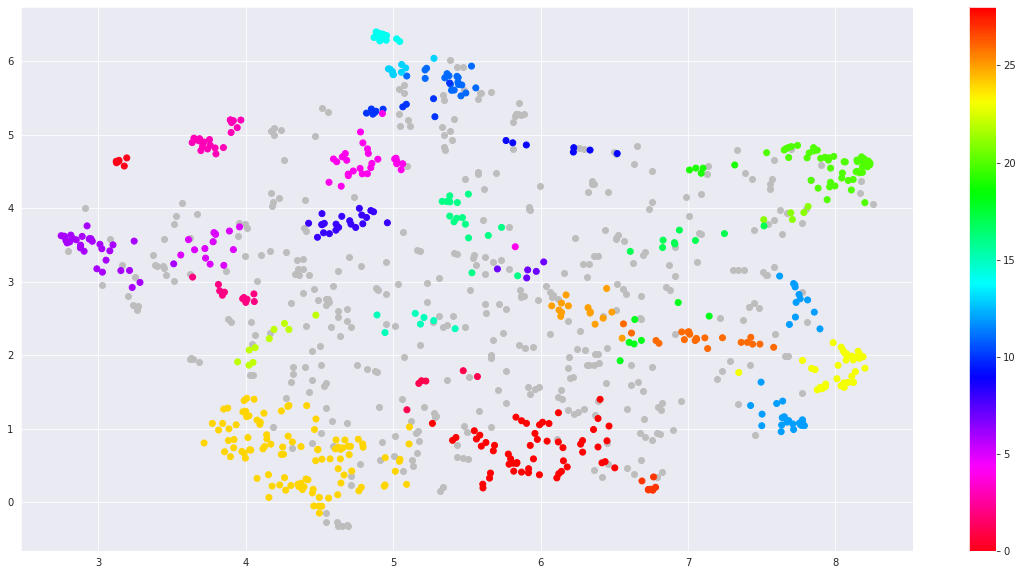

In [17]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

data = df.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 2mins

In [18]:
topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,408
1,0,8
2,1,6
3,2,11
4,3,22
5,4,28
6,5,14
7,6,31
8,7,5
9,8,22


In [21]:
joined_df = docs_df.join(df[['tier1', 'title']])
joined_df[joined_df.Topic==1].head()

# observation - biden related stuff pulled in with stimulus check. Bad clustering

,Doc,Topic,Doc_ID,tier1,title
7,"how should companies communicate csr on social media?. head, marketing and corporate communications for ub...",1,7,Technology & Computing,How Should Companies Communicate CSR On Social Media?
35,from startup to profitable venture: four common entrepreneurship questions. world no.1 linkedin & personal...,1,35,Business and Finance,From Startup To Profitable Venture: Four Common Entrepreneurship Questions
88,"big dreams, small brokerage: five traits of independent firms real estate agents should consider. kevin is...",1,88,Real Estate,"Big Dreams, Small Brokerage: Five Traits Of Independent Firms Real Estate Agents Should Consider"
382,3 reasons giving back is key to cultivating a younger audience: an interview with giuliano gigliotti. cann...,1,382,Business and Finance,3 Reasons Giving Back Is Key To Cultivating A Younger Audience: An Interview With Giuliano Gigliotti
805,britains minority businesses punch above their weight but they need help. minority businesses contribute a...,1,805,Business and Finance,Britain’s Minority Businesses Punch Above Their Weight But They Need Help


In [46]:
import json

with open('potential_good_topics_umap_15_5_hdbscan_5_art_embeds.txt', 'w') as file:
    json.dump(top_n_words, file)

In [47]:
joined_df.to_csv("potential_good_topics.csv", index=False)

992


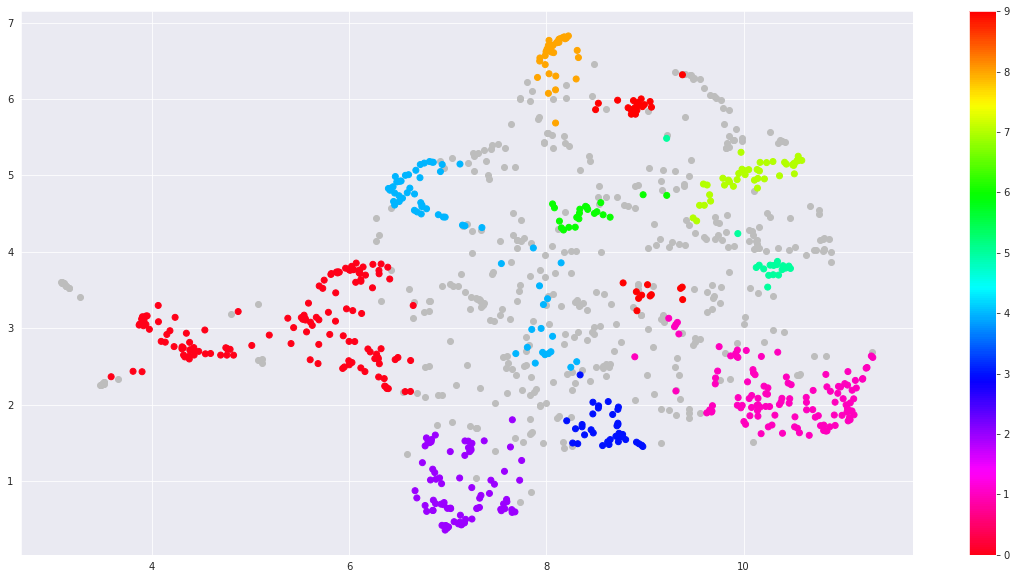

In [119]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=15, input = only noun tokens

data_2 = df.processed_noun_2.tolist()
print(len(data))

docs_df_2, top_n_words_2, topic_sizes_2 = algo(data_2) # 2mins

In [120]:
topic_sizes_2

,Topic,Size
0,-1,412
1,0,140
2,1,115
3,2,78
5,4,61
8,7,43
9,8,37
4,3,36
10,9,31
7,6,21


In [126]:
joined_df_2 = docs_df_2.join(df[['tier1', 'title']])
joined_df_2.to_csv("inspect-noun.csv", index=False)

# observation - biden related stuff pulled in with stimulus check. Bad clustering

992


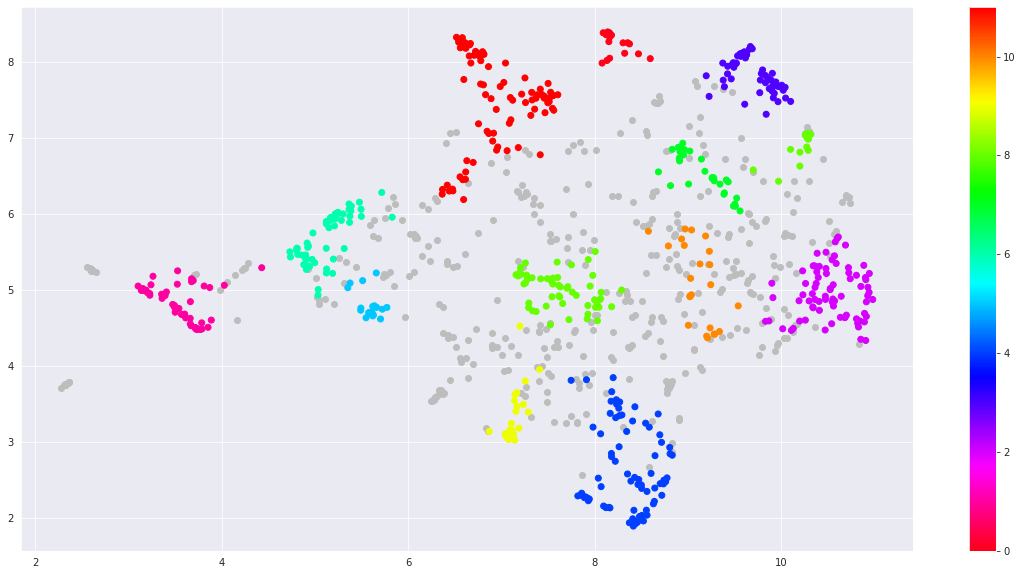

In [24]:
# Note = hdbscan min_cluster_size = 5 or 10, grouped everything together in 2 groups
# SETTINGS - umap:n_neighbors=10, n_components=50, hdbscan min_cluster_size=15, input = only noun tokens

data_3 = df.processed_noun_2.tolist()
print(len(data_3))

docs_df_3, top_n_words_3, topic_sizes_3 = algo(data_3) # 2mins

In [25]:
topic_sizes_3

,Topic,Size
0,-1,406
12,11,92
5,4,83
3,2,77
9,8,68
7,6,53
4,3,52
2,1,50
8,7,29
10,9,23


In [27]:
df.head(1)

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body,processed,processed_noun,processed_noun_2,article_length,max_sent_len
0,Computer Software and Applications,Technology & Computing,Computing,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,"[id=23]<h2 class=""subhead-embed color-accent bg-base font-accent font-size text-align"">OBSERVATIONS FROM T...",76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tan...,"[smartphone, owner, use, mobile, manage, finance, observation, fintech, snark, tank, new, study, cornersto...","[%, smartphone, owners, apps, finances, observations, fintech, snark, study, cornerstone, advisors, %, sma...",differences adults ground cards amzn billionis quarter generation observations rates something price corne...,777,49


In [ ]:
# Note = hdbscan min_cluster_size = 5 or 10, grouped everything together in 2 groups
# SETTINGS - umap:n_neighbors=10, n_components=50, hdbscan min_cluster_size=15, input = only noun tokens

data_4 = df.clean_body.tolist()
print(len(data_4))

docs_df_4, top_n_words_4, topic_sizes_4 = algo(data_4) # 2mins

In [ ]:
joined_df_3 = docs_df_3.join(df[['tier1', 'title']])
joined_df_3.to_csv("inspect-noun.csv", index=False)

# observation - biden related stuff pulled in with stimulus check. Bad clustering

### ALGO 2: Article as sentence embedding + k-Means

In [48]:
data_1 =  df.clean_body.tolist()
embeddings = model.encode(data_1)

In [49]:
# from sklearn.cluster import MiniBatchKMeans

# k = 30
# kmeans = MiniBatchKMeans(n_clusters = k)
# kmeans.fit(embeddings)
# centers = kmeans.cluster_centers_.argsort()[:,::-1]
# print(kmeans.labels_)

from nltk.cluster import KMeansClusterer

NUM_CLUSTERS=30

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(embeddings, assign_clusters=True) # takes a min

In [50]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = assigned_clusters
docs_df['Doc_ID'] = range(len(docs_df))

# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
11,11,60
0,0,49
27,27,46
23,23,44
22,22,44
3,3,41
4,4,41
19,19,41
12,12,41
17,17,40


In [52]:
joined_df = docs_df.join(df[['tier1', 'title']])
joined_df[joined_df.Topic==1].head()
joined_df.to_csv("kmeans_topic30_art_embeds.csv", index=False)
# observation - biden related stuff pulled in with stimulus check. Bad clustering

In [53]:
import json

with open('kmeans_topic30_art_embeds.txt', 'w') as file:
    json.dump(top_n_words, file)

### ALGO 3 - Embed every sentence and average vector to get article representation + HDBSCAN

* Why average with axis=0?
    * [Ref 1](https://stackoverflow.com/questions/49457715/averaging-vectors-from-a-corpus)
    * [Ref 2](http://yaronvazana.com/2018/09/20/average-word-vectors-generate-document-paragraph-sentence-embeddings/)
    * [Ref 3](https://www.reddit.com/r/MachineLearning/comments/dd9ns6/d_what_is_the_current_sota_in_document_embeddings/)

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

def algo_article_embed(data):
    
    # get embeddings
    # embeddings = model.encode(data)
    
    article_embeddings = []
    for article_body in data:

        embedding_sent = []
        art_sentences = sent_tokenize(article_body)
        for sent in art_sentences:
            embedding_sent.append(model.encode(sent))

        art_embed = np.mean(embedding_sent, axis=0)

        article_embeddings.append(art_embed) 
    print("article_embeddings len:", len(article_embeddings))

    # dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(article_embeddings) #min_dist=0.0,
    
    # cluster
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    # plot clusters and outliers
    # prepare data  - reduce to 2D for the purpose of plotting
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(article_embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD') #, s=20 lw=10
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r') # s=0.05, lw=10
    plt.colorbar()
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
    
    return docs_df, top_n_words, topic_sizes

992
article_embeddings len: 992


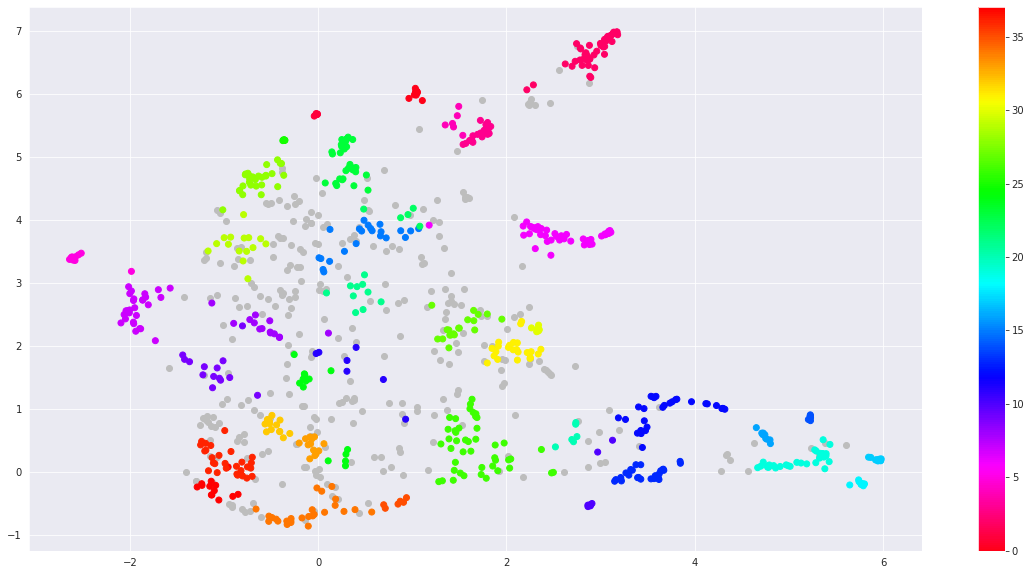

In [13]:
data_1 = df.clean_body.tolist()
print(len(data_1))

docs_df_1, top_n_words_1, topic_sizes_1 = algo_article_embed(data_1) # 20mins

In [15]:
topic_sizes_1.sort_values('Topic')

,Topic,Size
0,-1,311
1,0,11
2,1,6
3,2,49
4,3,19
5,4,6
6,5,13
7,6,45
8,7,29
9,8,14


In [18]:
joined_df = docs_df_1.join(df[['tier1', 'title']])
joined_df.to_csv("proper_avg_Art_embed_umap_15_5_hdbscan_5.csv", index=False)

import json

with open('proper_avg_Art_embed_umap_15_5_hdbscan_5.txt', 'w') as file:
    json.dump(top_n_words_1, file)

### ALGO 4: Top2Vec

In [12]:
from top2vec import Top2Vec

In [13]:
model = Top2Vec(data, embedding_model='universal-sentence-encoder') 

2021-03-14 19:16:04,336 - top2vec - INFO - Pre-processing documents for training
2021-03-14 19:16:06,700 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-03-14 19:16:20,633 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-14 19:16:25,670 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-14 19:16:34,359 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-14 19:16:34,470 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [14]:
model.get_num_topics()

12

In [15]:
topic_words, word_scores, topic_nums = model.get_topics(12)

In [17]:
topic_words

array([['startups', 'influencers', 'marketers', 'entrepreneurs',
        'sustainability', 'innovative', 'founder', 'startup',
        'consumers', 'invested', 'entrepreneur', 'sustainable', 'pfizer',
        'partnership', 'increasing', 'realize', 'founders', 'managing',
        'ceo', 'pandemic', 'expanding', 'collaboration', 'previously',
        'firms', 'meetings', 'leverage', 'launched', 'succeed',
        'develop', 'consumer', 'decided', 'customers', 'investor',
        'clients', 'executives', 'developed', 'venture', 'decline',
        'engagement', 'investors', 'individuals', 'limited',
        'independent', 'companys', 'unique', 'despite', 'brands',
        'affected', 'billion', 'nasdaq'],
       ['exclusive', 'series', 'audiences', 'launched', 'who',
        'influencers', 'netflix', 'leverage', 'community', 'venture',
        'unique', 'expanding', 'action', 'movies', 'cancellation',
        'largely', 'innovative', 'debut', 'happening', 'despite',
        'beyond', 'pop

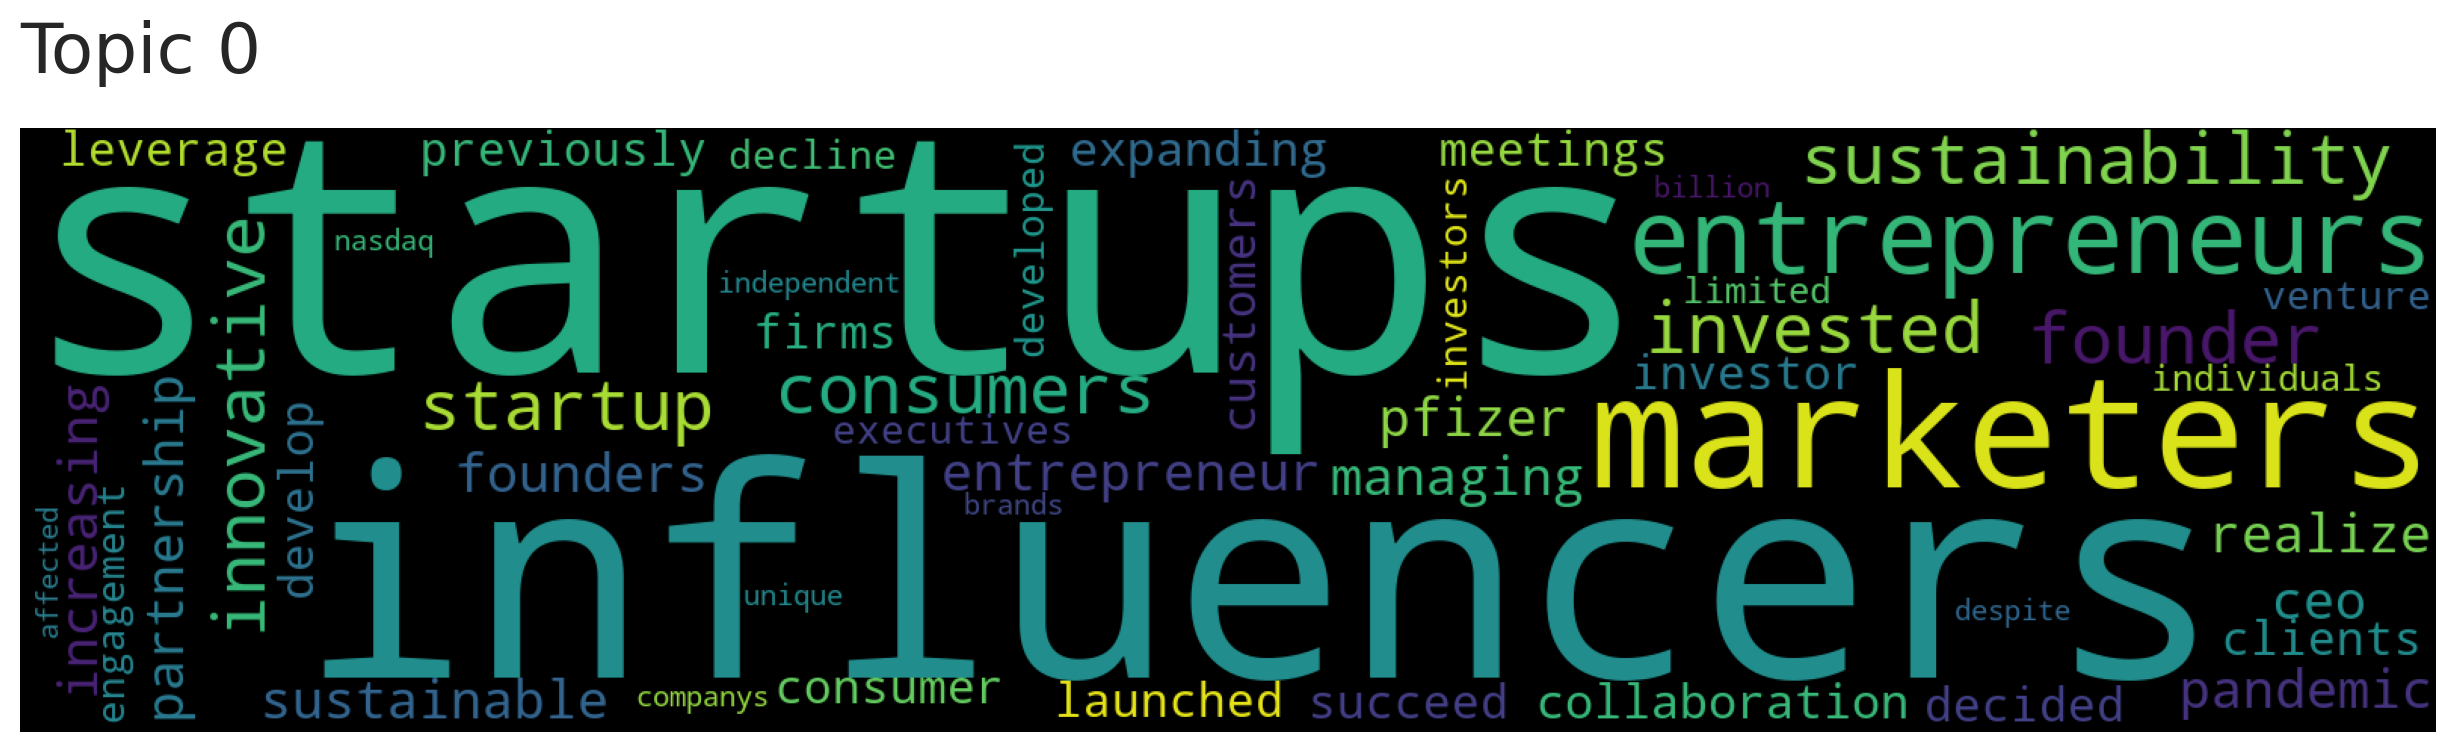

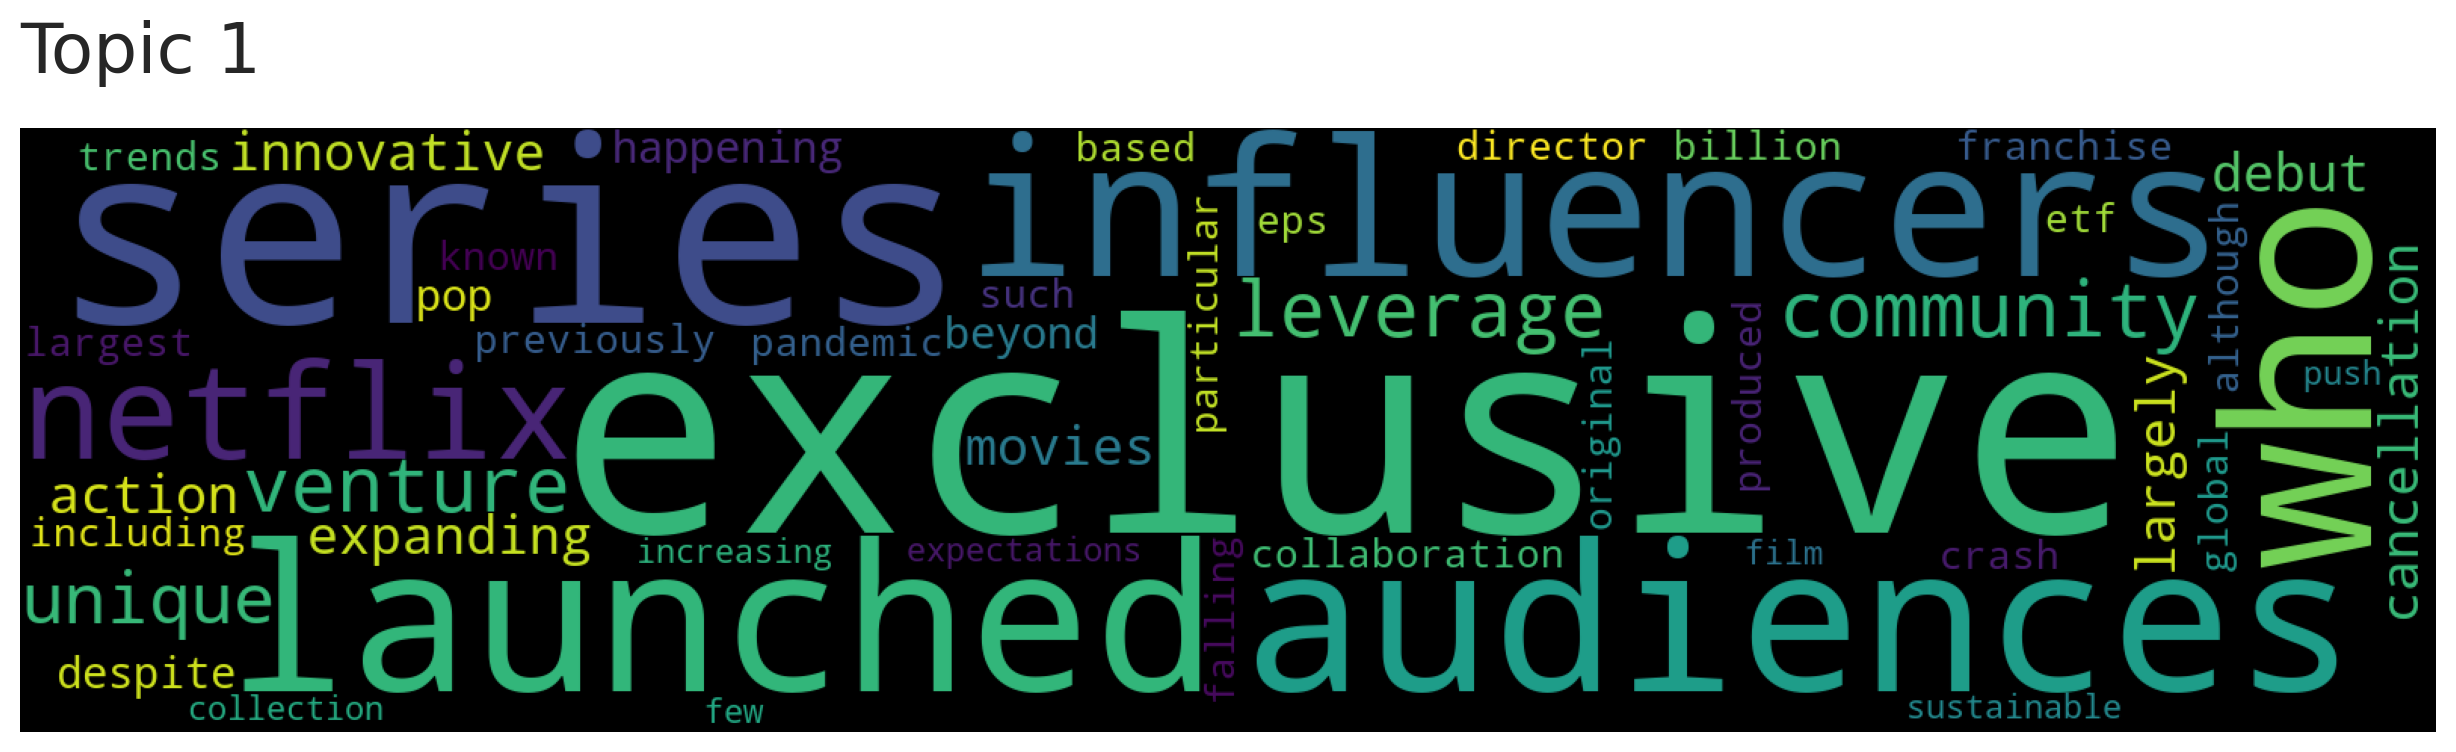

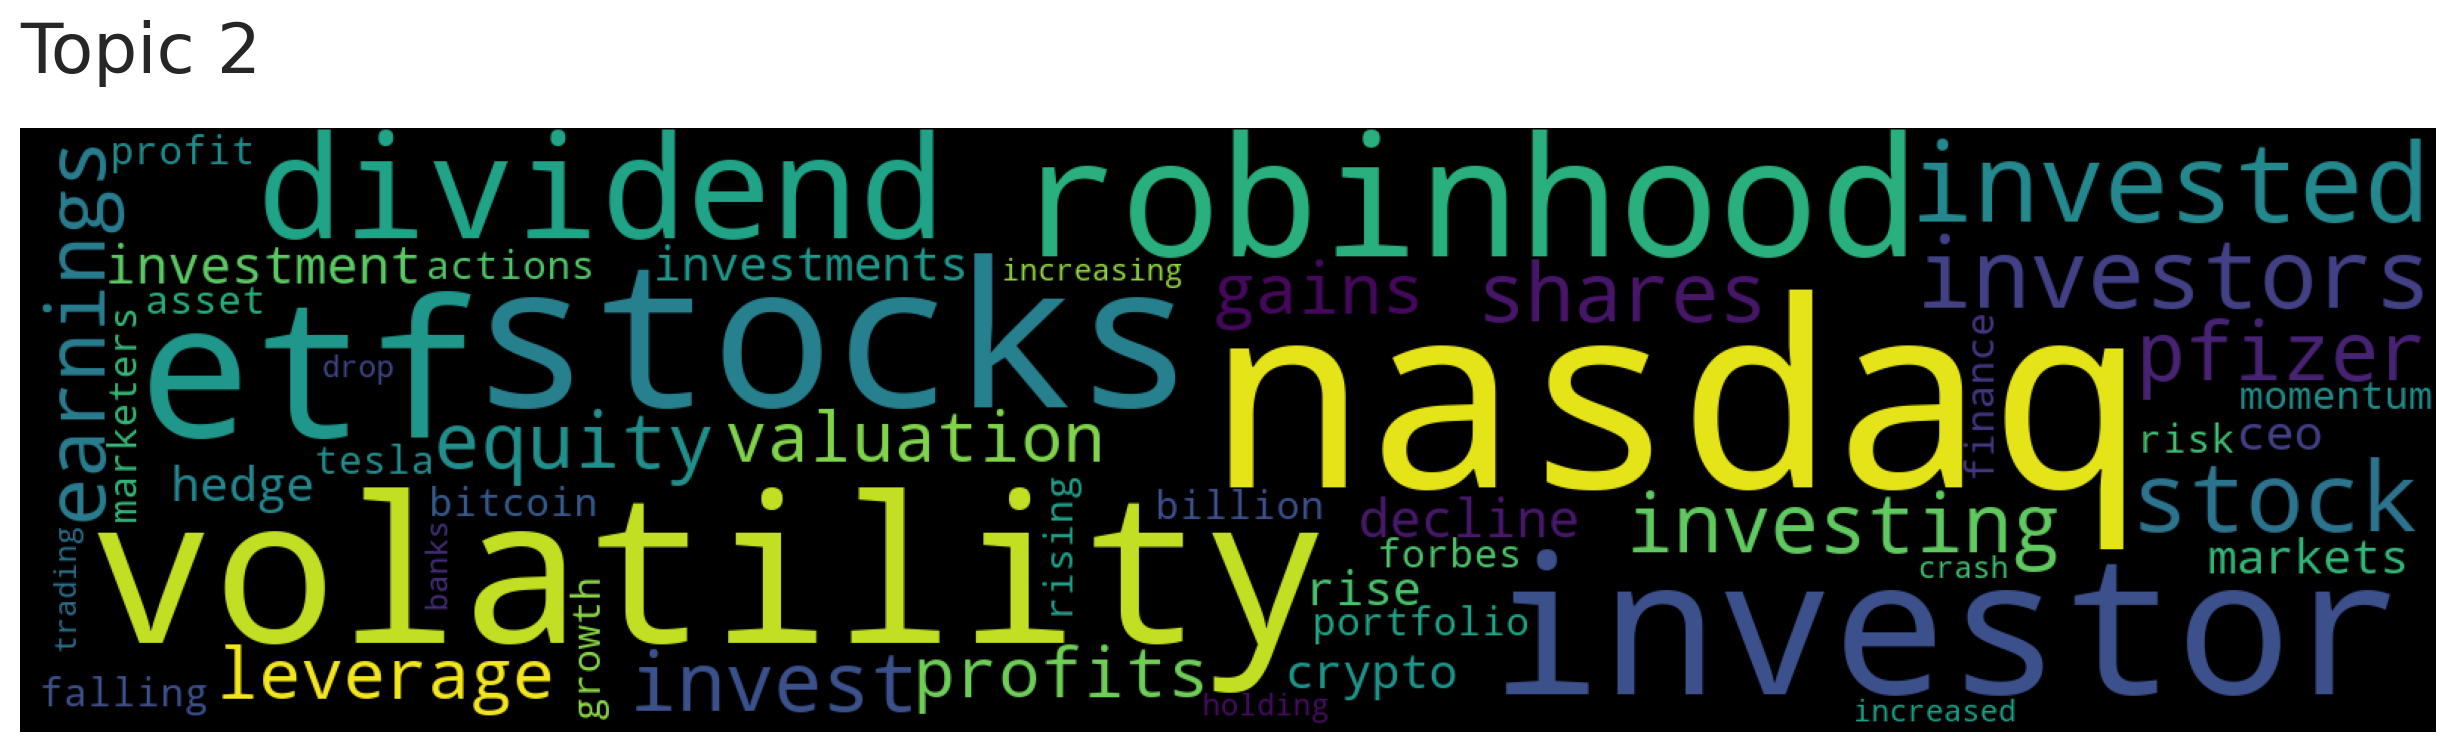

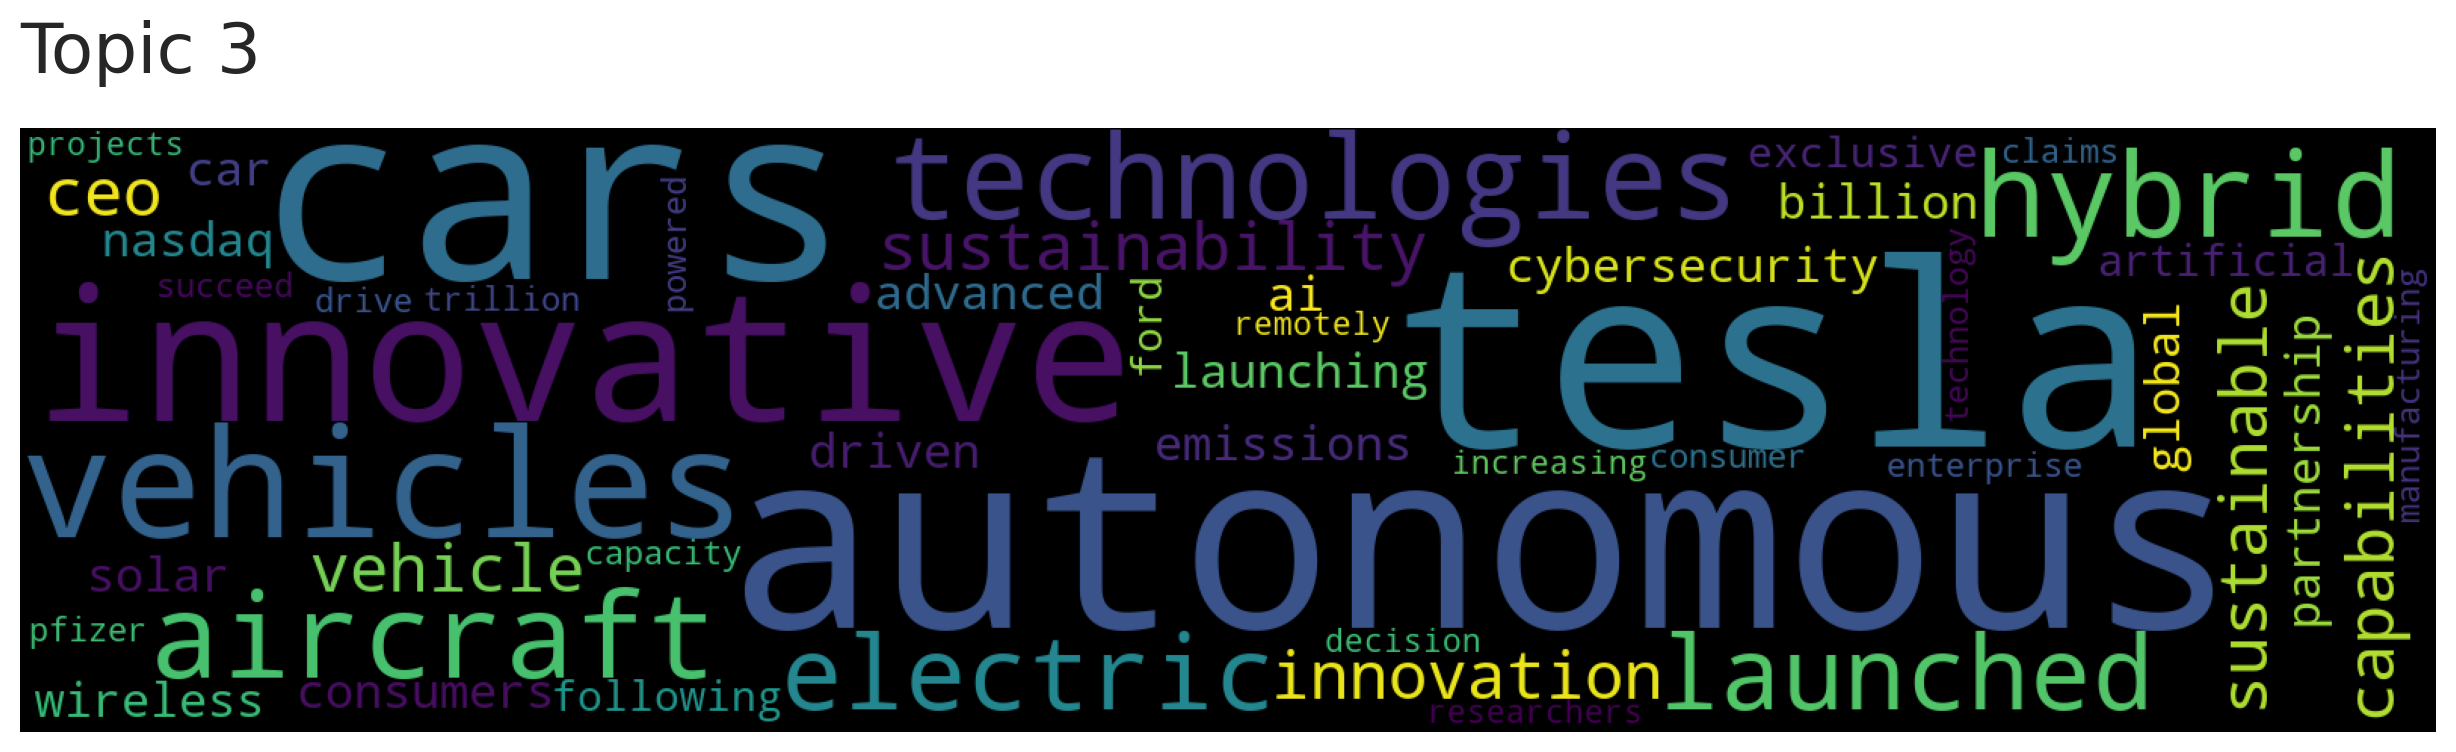

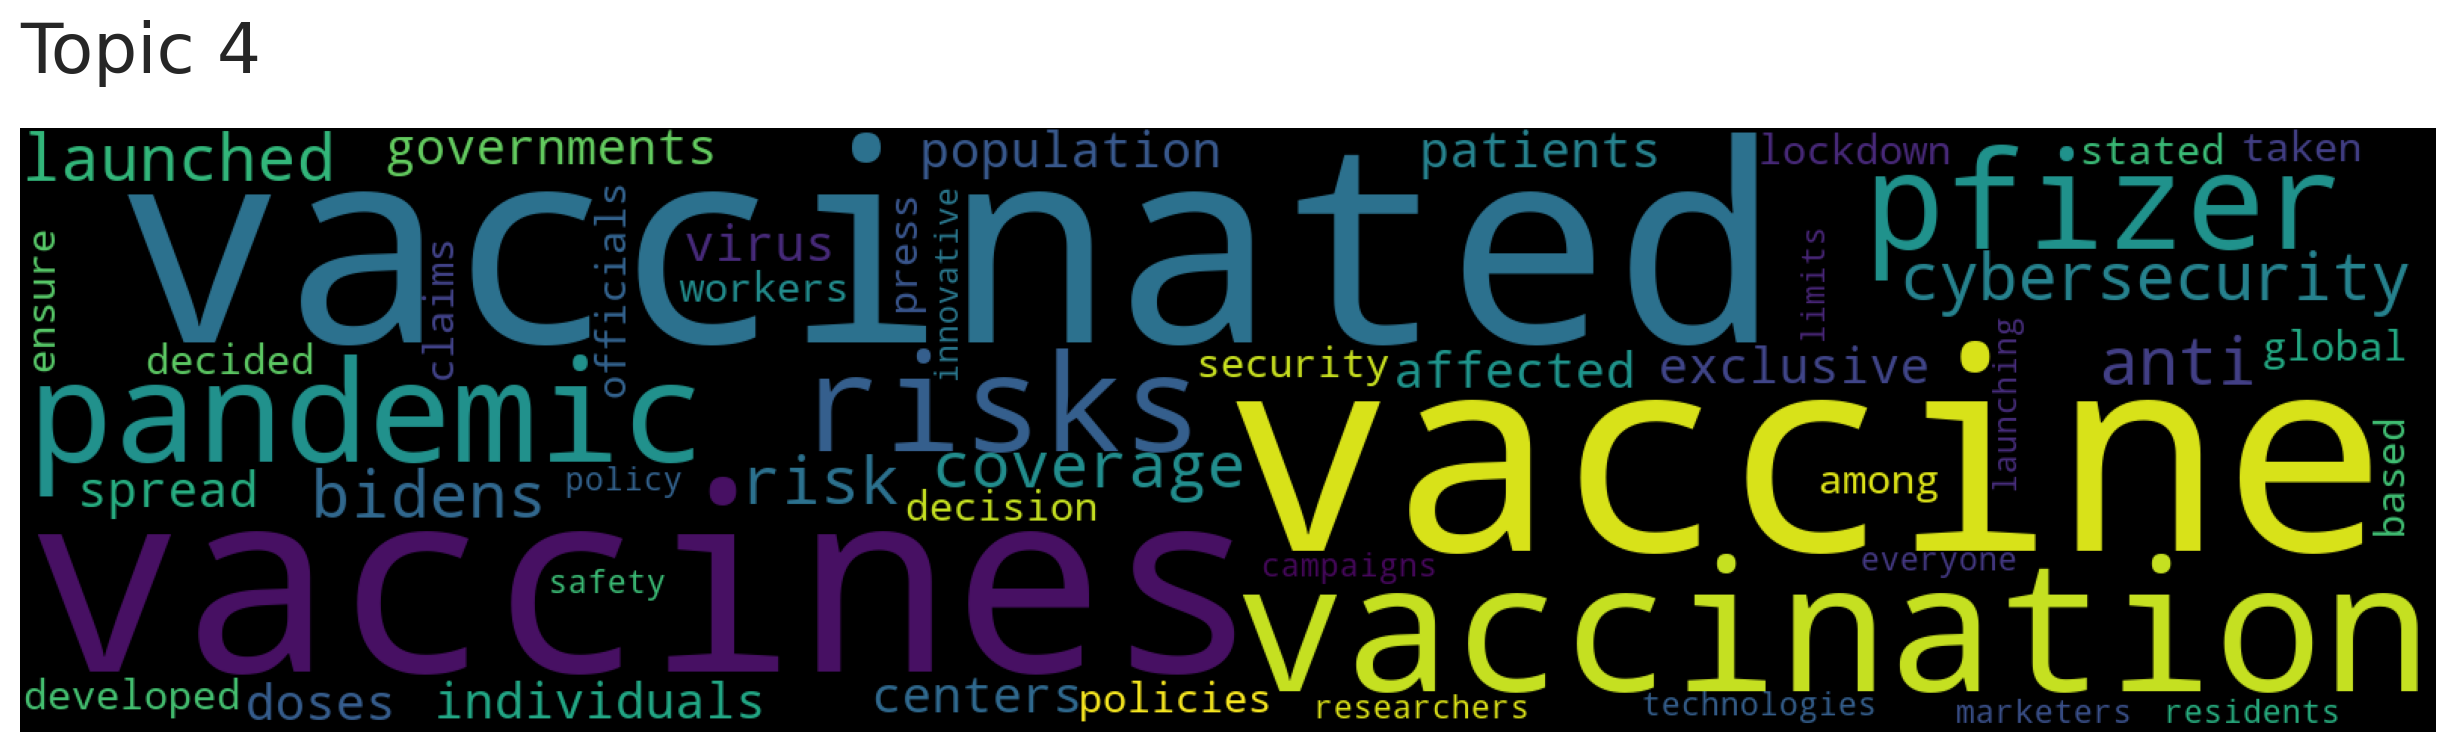

In [16]:
for topic in topic_nums[0:5]:
    model.generate_topic_wordcloud(topic, background_color="black")

In [ ]:
# TUTORIAL
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-max-tokens')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings)
print(len(sentence_embeddings[1]))

from sentence_transformers import util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

print(type(cos_sim))
print(len(embeddings[0]))

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))
